In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
# what will be done.
# outlier analysis
# forecasting horizon
# time series cross validation
# lag features
# predicting the future

In [3]:
df = pd.read_csv('PJME_hourly.csv')
df.set_index('Datetime', inplace=True)
df.index = pd.to_datetime(df.index)

In [4]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


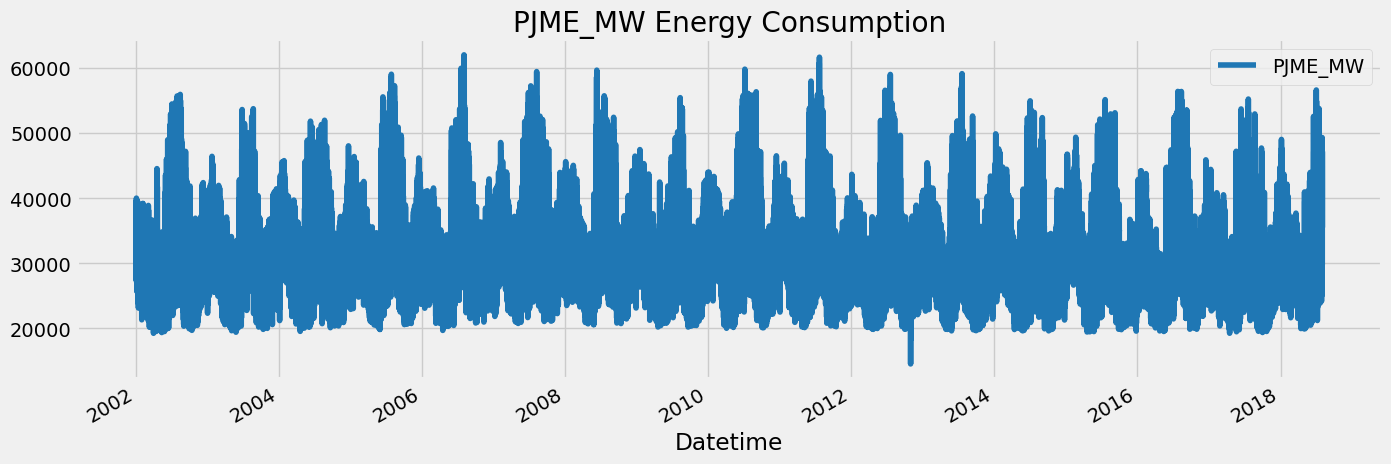

In [5]:
df.plot(figsize=(15, 5), color = color_pal[0], title='PJME_MW Energy Consumption')
plt.show()

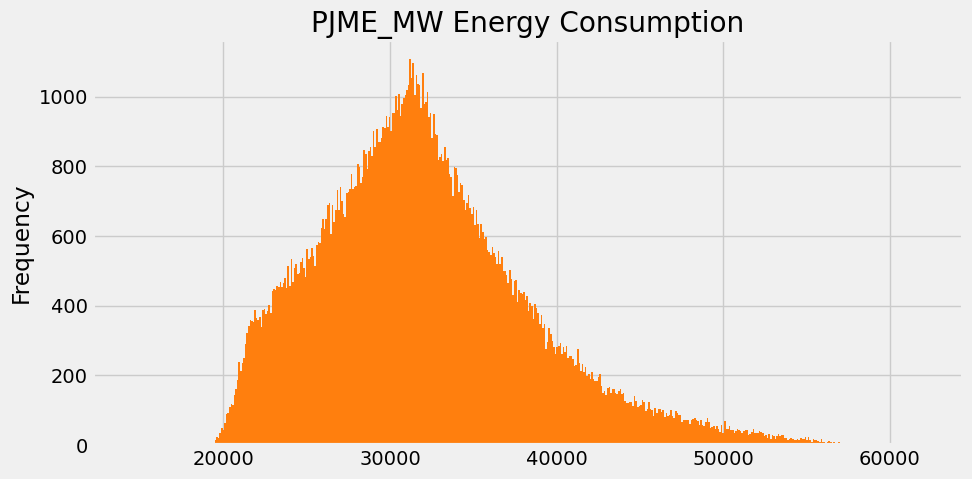

In [6]:
df['PJME_MW'].plot(kind = 'hist', bins = 500, figsize=(10, 5), color = color_pal[1], title='PJME_MW Energy Consumption')
plt.show()

<Axes: title={'center': 'outliers'}, xlabel='Datetime'>

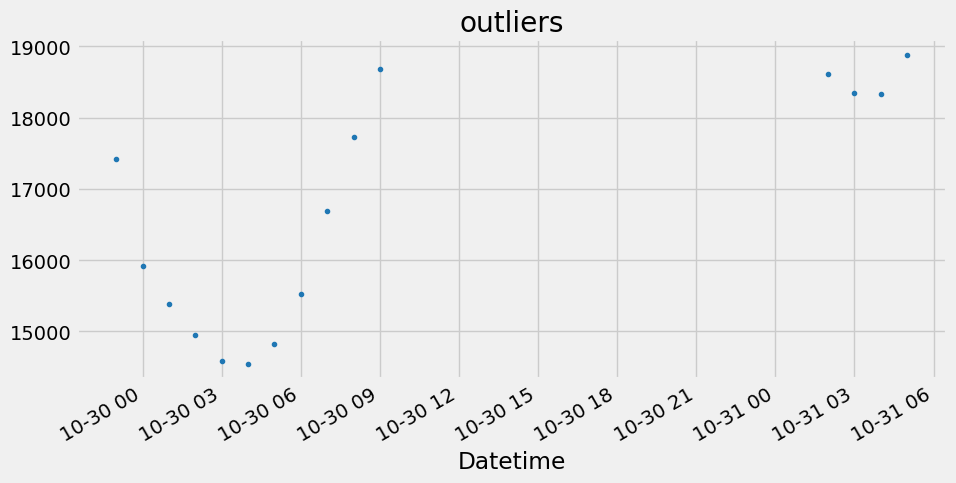

In [7]:
df.query('PJME_MW < 19_000')['PJME_MW'].plot(style='.',figsize=(10, 5), color = color_pal[0], title = 'outliers')

In [8]:
df = df.query('PJME_MW > 19_000')

In [9]:
# time series cross validation
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

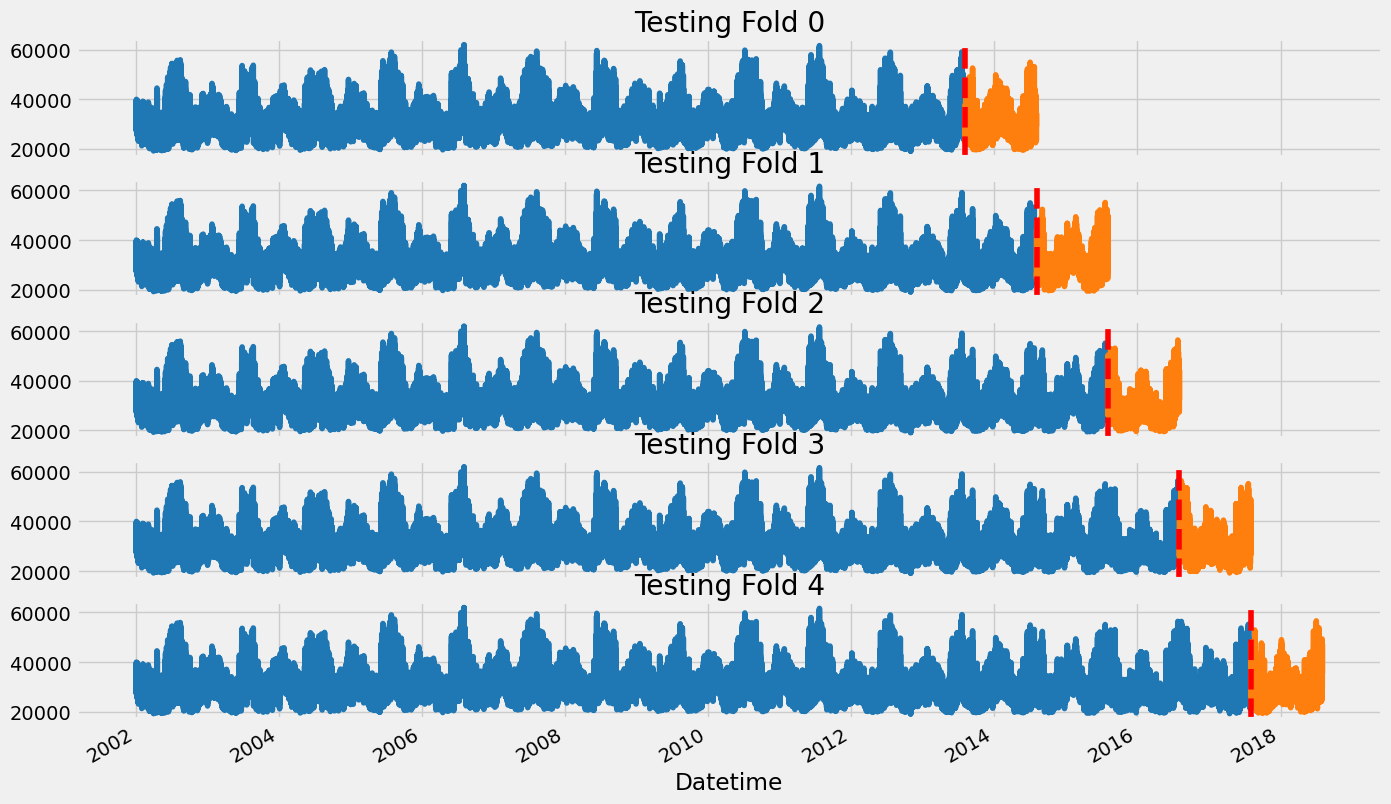

In [10]:
fig, axs = plt.subplots(5, 1, figsize=(15, 10),
                        sharex=True)

fold = 0
for train_index, test_index in tss.split(df):
    train = df.iloc[train_index]
    test = df.iloc[test_index]
    train['PJME_MW'].plot(ax=axs[fold], color=color_pal[0], title='Training Fold {}'.format(fold))
    test['PJME_MW'].plot(ax=axs[fold], color=color_pal[1], title='Testing Fold {}'.format(fold))
    axs[fold].axvline(test.index.min(), color='r', linestyle='--')
    fold += 1

In [11]:
# Feature Creation
def create_features(df): 
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [12]:
target_map = df['PJME_MW'].to_dict()

In [13]:
def add_lags(df):
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)

    return df

df = add_lags(df)

In [14]:
df.tail()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
Datetime,,,,,,,,,,,,
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31,42256.0,41485.0,38804.0
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31,41210.0,40249.0,38748.0
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31,39525.0,38698.0,37330.0
2018-08-02 23:00:00,38500.0,23,3,3,8,2018,214,2,31,36490.0,35406.0,34552.0
2018-08-03 00:00:00,35486.0,0,4,3,8,2018,215,3,31,33539.0,32094.0,31695.0


In [15]:
# train using cv

tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

fold = 0
preds = []
scores = []
for train_index, test_index in tss.split(df):
    train = df.iloc[train_index]
    test = df.iloc[test_index]

    train = create_features(train)
    test = create_features(test)

    features = ['hour', 'dayofweek', 'quarter', 'month', 'year',
                'dayofyear', 'dayofmonth', 'weekofyear', 'lag1', 'lag2', 'lag3']
    target = 'PJME_MW'

    X_train = train[features]
    y_train = train[target]

    X_test = test[features]
    y_test = test[target]

    reg = xgb.XGBRegressor(base_score = 0.5,booster = 'gbtree',
                           n_estimators=1000,
                           objective = 'reg:linear',
                           max_depth=3,
                           learning_rate=0.1)

    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = mean_squared_error(y_test, y_pred)
    scores.append(score)



[0]	validation_0-rmse:29808.12865	validation_1-rmse:29056.13437


c:\Users\ziadz\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [06:10:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:3114.27685	validation_1-rmse:3821.86610
[200]	validation_0-rmse:2916.21528	validation_1-rmse:3746.84007
[300]	validation_0-rmse:2799.44506	validation_1-rmse:3717.90952
[400]	validation_0-rmse:2719.96428	validation_1-rmse:3696.38712
[500]	validation_0-rmse:2649.30914	validation_1-rmse:3696.02274
[600]	validation_0-rmse:2589.89565	validation_1-rmse:3738.30412
[700]	validation_0-rmse:2546.91699	validation_1-rmse:3770.87252
[800]	validation_0-rmse:2501.64425	validation_1-rmse:3785.21372
[900]	validation_0-rmse:2461.32027	validation_1-rmse:3792.96901
[999]	validation_0-rmse:2424.12058	validation_1-rmse:3837.13791
[0]	validation_0-rmse:29753.15584	validation_1-rmse:29241.17577


c:\Users\ziadz\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [06:10:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:3155.84046	validation_1-rmse:3423.17310
[200]	validation_0-rmse:2954.24092	validation_1-rmse:3415.06596
[300]	validation_0-rmse:2849.46170	validation_1-rmse:3426.38950
[400]	validation_0-rmse:2766.59500	validation_1-rmse:3420.07506
[500]	validation_0-rmse:2699.66781	validation_1-rmse:3418.16720
[600]	validation_0-rmse:2644.91020	validation_1-rmse:3461.18118
[700]	validation_0-rmse:2599.71464	validation_1-rmse:3482.90076
[800]	validation_0-rmse:2557.22565	validation_1-rmse:3510.07281
[900]	validation_0-rmse:2516.57773	validation_1-rmse:3509.48866
[999]	validation_0-rmse:2481.24835	validation_1-rmse:3519.47479
[0]	validation_0-rmse:29715.65212	validation_1-rmse:28164.14597


c:\Users\ziadz\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [06:10:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:3183.68152	validation_1-rmse:3740.62344
[200]	validation_0-rmse:2992.25663	validation_1-rmse:3879.10600
[300]	validation_0-rmse:2884.00475	validation_1-rmse:3954.95964
[400]	validation_0-rmse:2807.87373	validation_1-rmse:3978.84574
[500]	validation_0-rmse:2748.52080	validation_1-rmse:4131.61209
[600]	validation_0-rmse:2693.48430	validation_1-rmse:4162.11421
[700]	validation_0-rmse:2647.87721	validation_1-rmse:4212.24775
[800]	validation_0-rmse:2604.55920	validation_1-rmse:4273.57252
[900]	validation_0-rmse:2567.20032	validation_1-rmse:4369.03760
[999]	validation_0-rmse:2531.87697	validation_1-rmse:4513.54259
[0]	validation_0-rmse:29622.40485	validation_1-rmse:28639.90195


c:\Users\ziadz\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [06:10:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:3195.25684	validation_1-rmse:4051.94510
[200]	validation_0-rmse:3016.09349	validation_1-rmse:3983.81607
[300]	validation_0-rmse:2905.57614	validation_1-rmse:3910.88446
[400]	validation_0-rmse:2829.77278	validation_1-rmse:3881.16326
[500]	validation_0-rmse:2762.29110	validation_1-rmse:3862.66614
[600]	validation_0-rmse:2706.01816	validation_1-rmse:3831.92072
[700]	validation_0-rmse:2660.25732	validation_1-rmse:3822.72655
[800]	validation_0-rmse:2620.47782	validation_1-rmse:3826.62222
[900]	validation_0-rmse:2580.49627	validation_1-rmse:3836.34568
[999]	validation_0-rmse:2550.74850	validation_1-rmse:3838.34359
[0]	validation_0-rmse:29562.51806	validation_1-rmse:28619.93828


c:\Users\ziadz\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [06:10:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:3232.96502	validation_1-rmse:4069.15313
[200]	validation_0-rmse:3051.60978	validation_1-rmse:4071.39392
[300]	validation_0-rmse:2945.16326	validation_1-rmse:4099.35014
[400]	validation_0-rmse:2867.23289	validation_1-rmse:4102.95644
[500]	validation_0-rmse:2806.33743	validation_1-rmse:4100.17577
[600]	validation_0-rmse:2750.87494	validation_1-rmse:4124.82268
[700]	validation_0-rmse:2700.28288	validation_1-rmse:4178.73059
[800]	validation_0-rmse:2662.65142	validation_1-rmse:4191.39633
[900]	validation_0-rmse:2622.03741	validation_1-rmse:4224.92040
[999]	validation_0-rmse:2585.68940	validation_1-rmse:4210.07504


In [16]:
print('Mean Score:', np.mean(scores))
print('Fold Scores:', scores)

Mean Score: 15988002.047951777
Fold Scores: [14723627.359498575, 12386702.816723755, 20372066.711926546, 14732881.486561881, 17724731.86504812]


In [17]:
# retrain on all data
df = create_features(df)
features = ['hour', 'dayofweek', 'quarter', 'month', 'year',
            'dayofyear', 'dayofmonth', 'weekofyear', 'lag1', 'lag2', 'lag3']
target = 'PJME_MW'

X_train = df[features]
y_train = df[target]

reg = xgb.XGBRegressor(base_score = 0.5,booster = 'gbtree',
                          n_estimators=500,
                          objective = 'reg:linear',
                          max_depth=3,
                          learning_rate=0.1)

reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train)],
        verbose=100)

[0]	validation_0-rmse:29509.98192


c:\Users\ziadz\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [06:10:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:3282.02104
[200]	validation_0-rmse:3097.03753
[300]	validation_0-rmse:2994.43721
[400]	validation_0-rmse:2922.01077
[499]	validation_0-rmse:2854.03004


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [18]:
fi = pd.DataFrame(data = reg.feature_importances_,
             index = X_train.columns,
             columns = ['Importance'])

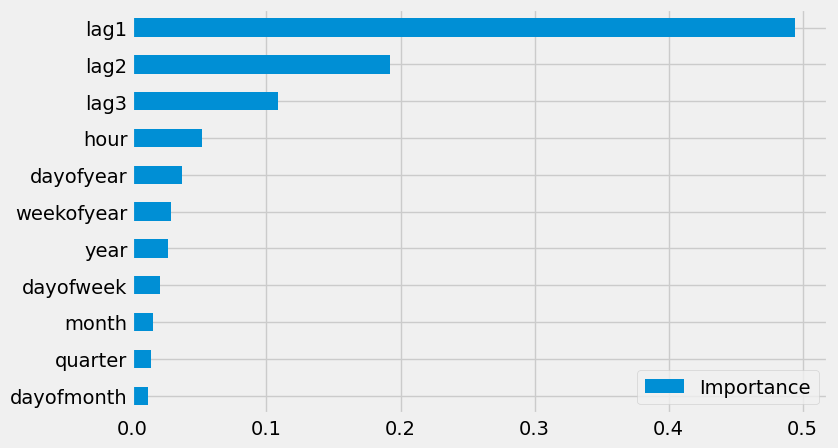

In [19]:
fi.sort_values(by='Importance', ascending=True).plot(kind='barh', figsize=(8,5))
plt.show()

In [20]:
# create future dates
future_dates = pd.date_range(df.index.max(), periods=24*364*1, freq='1h')
future_df = pd.DataFrame(index=future_dates)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [21]:
future_with_features = df_and_future.query('isFuture').copy()

In [22]:
future_with_features

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,isFuture
2018-08-03 00:00:00,NaN,0,4,3,8,2018,215,3,31,33539.0,32094.0,31695.0,True
2018-08-03 01:00:00,NaN,1,4,3,8,2018,215,3,31,30781.0,29503.0,29128.0,True
2018-08-03 02:00:00,NaN,2,4,3,8,2018,215,3,31,29015.0,27712.0,27373.0,True
2018-08-03 03:00:00,NaN,3,4,3,8,2018,215,3,31,27884.0,26535.0,26233.0,True
2018-08-03 04:00:00,NaN,4,4,3,8,2018,215,3,31,27223.0,25870.0,25643.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-01 19:00:00,NaN,19,3,3,8,2019,213,1,31,45641.0,44429.0,43375.0,True
2019-08-01 20:00:00,NaN,20,3,3,8,2019,213,1,31,44057.0,42256.0,41485.0,True
2019-08-01 21:00:00,NaN,21,3,3,8,2019,213,1,31,43256.0,41210.0,40249.0,True
2019-08-01 22:00:00,NaN,22,3,3,8,2019,213,1,31,41552.0,39525.0,38698.0,True


In [23]:
## predict the future
future_with_features['pred'] = reg.predict(future_with_features[features])

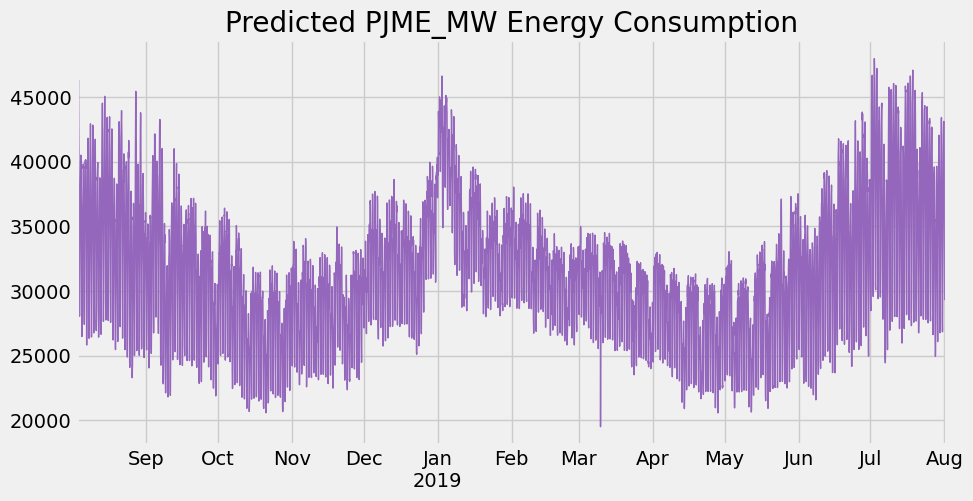

In [24]:
future_with_features['pred'].plot(figsize=(10, 5), color=color_pal[4],ms = 1, lw = 1, title='Predicted PJME_MW Energy Consumption')
plt.show()

In [25]:
# save model
import joblib
joblib.dump(reg, 'model.pkl')

['model.pkl']